# Imports

In [75]:
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
from keras.models import load_model
import random
import tensorflow as tf

# Constants

In [76]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
NUM_CLASSES = 10

train_dir = './dataset/train'
val_dir = './dataset/val'
test_dir = './dataset/test'

# Function to create data generators

In [77]:
def create_data_generators(phase):
    if phase == 3:  # Data augmentation for Phase 3
        train_datagen = ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:  # Only scaling for Phase 1 and Phase 2
        train_datagen = ImageDataGenerator(rescale=1. / 255)

    val_test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator, val_generator, test_generator

# Function to train a model

In [78]:
def train_model(model, train_gen, val_gen, epochs=20, phase=1):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint(
        'phase' + str(phase) + '_best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )
    # Save the model after training
    model.save(f'model_phase_{phase}.keras')
    print(f"Model for Phase {phase} saved as 'model_phase_{phase}.keras'")
    return history

# Function to plot learning curves

In [79]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

# Function to evaluate the model

In [80]:
def evaluate_model(model, test_gen):
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    y_true = test_gen.classes
    y_pred_prob = model.predict(test_gen)
    y_pred = np.argmax(y_pred_prob, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(),
                yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    y_true_binary = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
    plt.figure(figsize=(12, 8))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {list(test_gen.class_indices.keys())[i]} (AUC: {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# visualize predictions

In [81]:
def visualize_random_predictions(model, test_gen, num_images=10):
    x_test, y_test = next(test_gen)
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Randomly select indices
    random_indices = random.sample(range(len(x_test)), min(num_images, len(x_test)))

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.squeeze(x_test[idx]))  # Squeeze in case of single-channel images
        true_label = list(test_gen.class_indices.keys())[y_true_classes[idx]]
        pred_label = list(test_gen.class_indices.keys())[y_pred_classes[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Phase 1: Model with 1,400,000 parameters (no data augmentation)

In [82]:
def create_phase_1_model(input_shape=(128, 128, 3), num_classes=10):
    model = models.Sequential()

    # Convolutional Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Convolutional Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Convolutional Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Fully Connected Layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Phase 2: Adjusted model with 400,000 parameters (reuse Phase 1 architecture)

In [83]:
def create_phase_2_model(phase_1_model, num_classes=10):
    phase_2_model = models.Sequential()

    # Reuse all convolutional and pooling layers from phase_1_model, excluding dense layers
    for layer in phase_1_model.layers[:-4]:  # Skip the dense and dropout layers from phase 1
        phase_2_model.add(layer)

    # Add new Dense layers to maximize parameters within 400,000 limit
    phase_2_model.add(layers.Flatten())  # Ensure input is flattened for Dense layers
    phase_2_model.add(layers.Dense(8, activation='relu'))
    phase_2_model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    phase_2_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return phase_2_model

# Phase 3: Overfitting prevention

In [84]:
def apply_overfitting_prevention(model):
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
            layer.kernel_regularizer = regularizers.l2(0.001)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Execution for Phase 1

In [85]:
train_generator, val_generator, test_generator = create_data_generators(phase=1)

Found 16938 images belonging to 10 classes.
Found 2425 images belonging to 10 classes.
Found 4846 images belonging to 10 classes.


In [86]:
model_phase_1 = create_phase_1_model()

In [87]:
model_phase_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_20 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_21 (Ba  (None, 64, 64, 64)       

In [88]:
history_phase_1 = train_model(model_phase_1, train_generator, val_generator, phase=1)

Epoch 1/20
530/530 [==============================] - ETA: 0s - loss: 2.2560 - accuracy: 0.2990
Epoch 1: val_loss improved from inf to 2.16359, saving model to phase1_best_model.h5


D:\python 3.8.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


530/530 [==============================] - 389s 730ms/step - loss: 2.2560 - accuracy: 0.2990 - val_loss: 2.1636 - val_accuracy: 0.2718 - lr: 0.0010
Epoch 2/20
530/530 [==============================] - ETA: 0s - loss: 1.6473 - accuracy: 0.4357
Epoch 2: val_loss improved from 2.16359 to 1.95493, saving model to phase1_best_model.h5
530/530 [==============================] - 403s 761ms/step - loss: 1.6473 - accuracy: 0.4357 - val_loss: 1.9549 - val_accuracy: 0.4243 - lr: 0.0010
Epoch 3/20
530/530 [==============================] - ETA: 0s - loss: 1.3362 - accuracy: 0.5443
Epoch 3: val_loss improved from 1.95493 to 1.90426, saving model to phase1_best_model.h5
530/530 [==============================] - 399s 752ms/step - loss: 1.3362 - accuracy: 0.5443 - val_loss: 1.9043 - val_accuracy: 0.4181 - lr: 0.0010
Epoch 4/20
530/530 [==============================] - ETA: 0s - loss: 1.1469 - accuracy: 0.6108
Epoch 4: val_loss improved from 1.90426 to 1.11228, saving model to phase1_best_model.h5
5

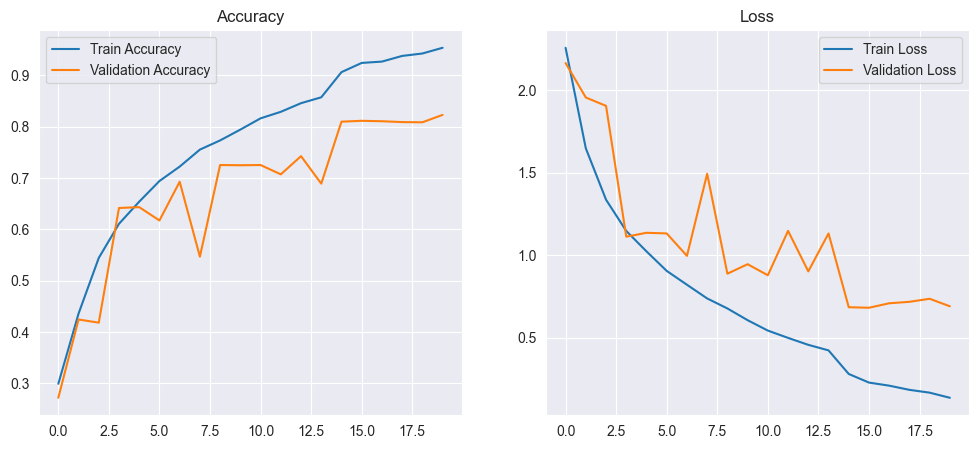

In [89]:
plot_learning_curves(history_phase_1)

152/152 [==============================] - 27s 176ms/step - loss: 0.6358 - accuracy: 0.8343
Test Loss: 0.6357561945915222
Test Accuracy: 0.8342963457107544
152/152 [==============================] - 26s 171ms/step


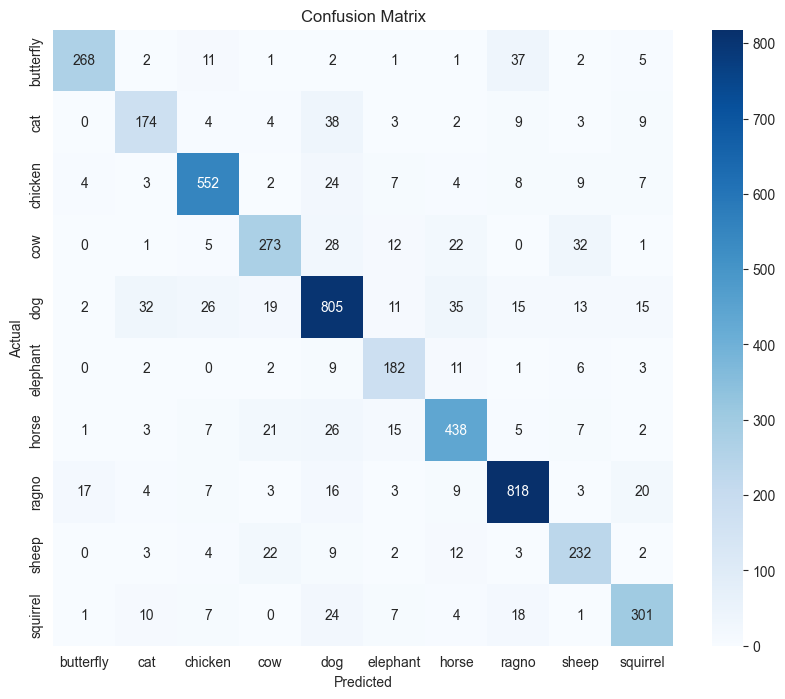

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.91      0.81      0.86       330
         cat       0.74      0.71      0.72       246
     chicken       0.89      0.89      0.89       620
         cow       0.79      0.73      0.76       374
         dog       0.82      0.83      0.82       973
    elephant       0.75      0.84      0.79       216
       horse       0.81      0.83      0.82       525
       ragno       0.89      0.91      0.90       900
       sheep       0.75      0.80      0.78       289
    squirrel       0.82      0.81      0.82       373

    accuracy                           0.83      4846
   macro avg       0.82      0.82      0.82      4846
weighted avg       0.84      0.83      0.83      4846



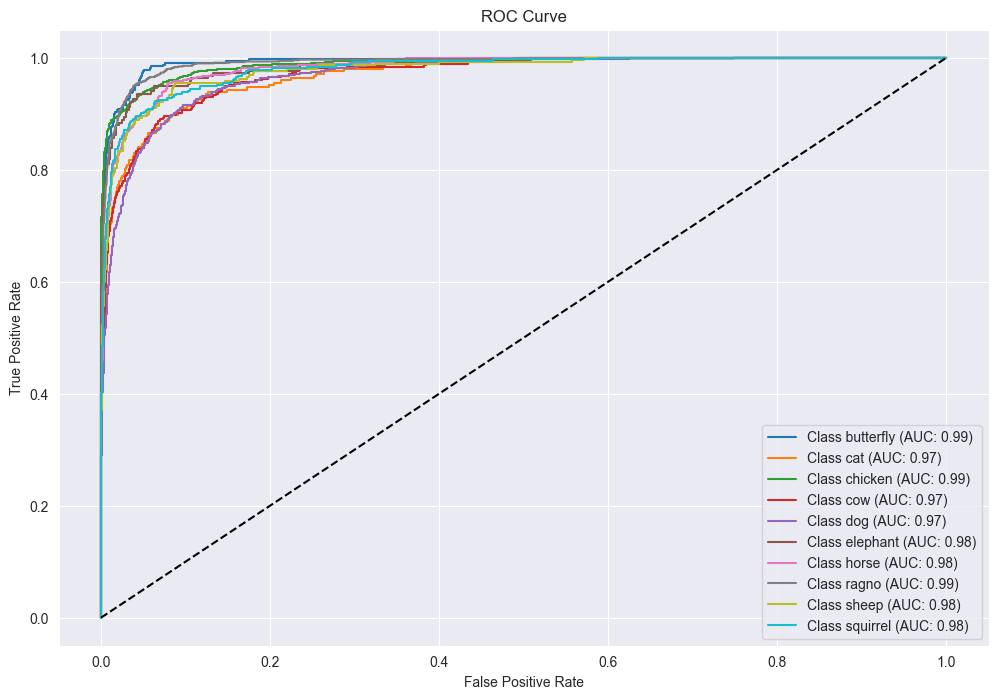

In [90]:
evaluate_model(model_phase_1, test_generator)

1/1 [==============================] - 0s 296ms/step


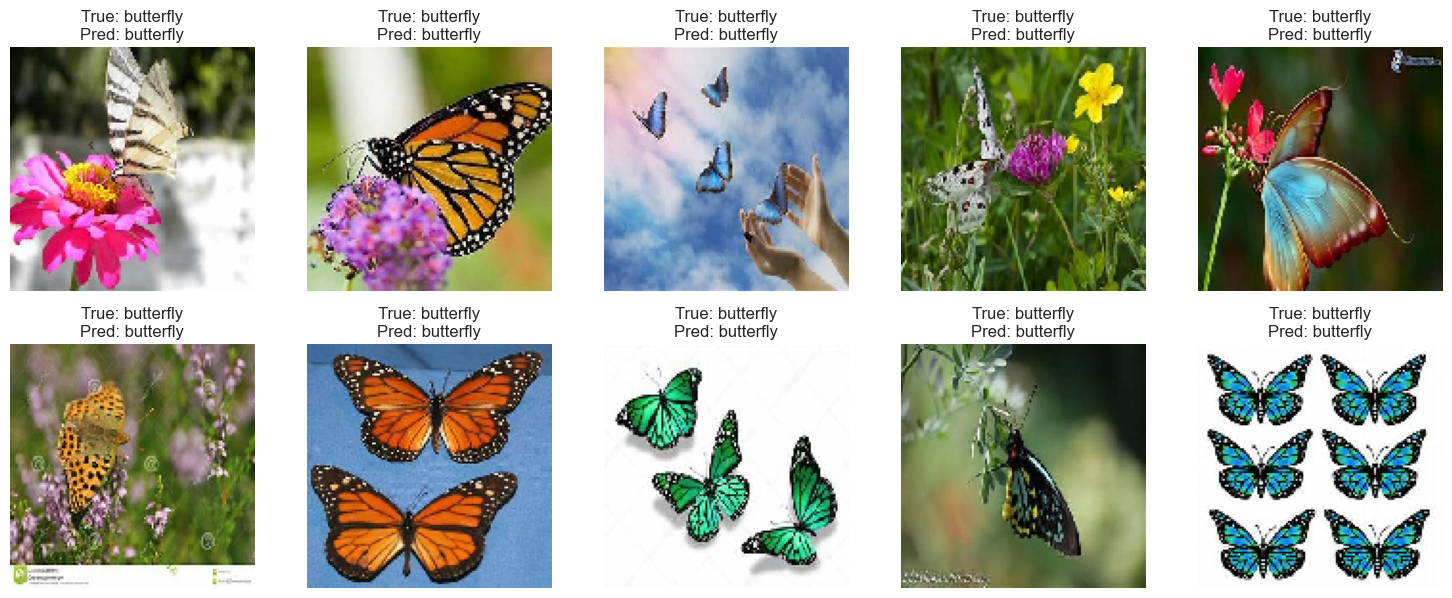

In [91]:
visualize_random_predictions(model_phase_1, test_generator)

# Execution for Phase 2

In [92]:
model_phase_2 = create_phase_2_model(model_phase_1)

In [93]:
model_phase_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_20 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_21 (Ba  (None, 64, 64, 64)       

In [94]:
history_phase_2 = train_model(model_phase_2, train_generator, val_generator, phase=2)

Epoch 1/20
530/530 [==============================] - ETA: 0s - loss: 1.1582 - accuracy: 0.6092
Epoch 1: val_loss improved from inf to 0.98605, saving model to phase2_best_model.h5
530/530 [==============================] - 401s 753ms/step - loss: 1.1582 - accuracy: 0.6092 - val_loss: 0.9861 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 2/20


D:\python 3.8.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


530/530 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.7966
Epoch 2: val_loss improved from 0.98605 to 0.93244, saving model to phase2_best_model.h5
530/530 [==============================] - 396s 748ms/step - loss: 0.6304 - accuracy: 0.7966 - val_loss: 0.9324 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 3/20
530/530 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.8444
Epoch 3: val_loss improved from 0.93244 to 0.85792, saving model to phase2_best_model.h5
530/530 [==============================] - 398s 750ms/step - loss: 0.4840 - accuracy: 0.8444 - val_loss: 0.8579 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 4/20
530/530 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.8687
Epoch 4: val_loss improved from 0.85792 to 0.79938, saving model to phase2_best_model.h5
530/530 [==============================] - 413s 780ms/step - loss: 0.4089 - accuracy: 0.8687 - val_loss: 0.7994 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 5/20
5

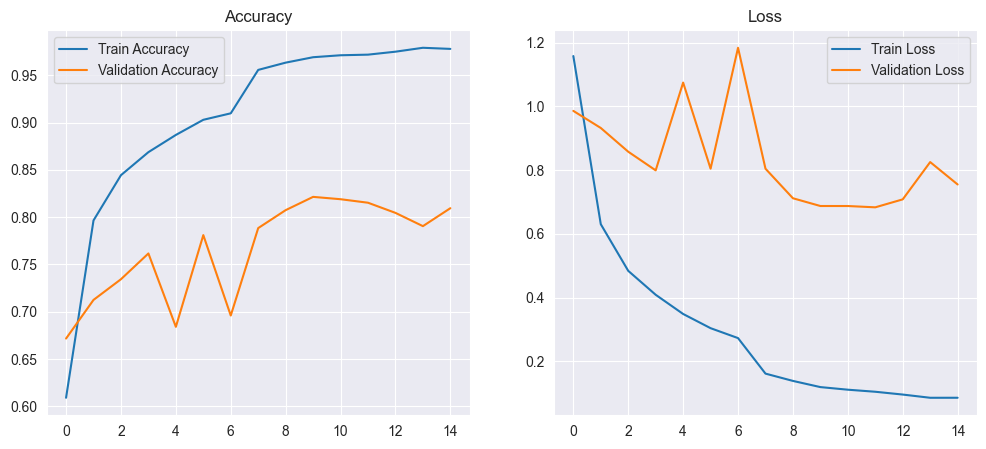

In [95]:
plot_learning_curves(history_phase_2)

152/152 [==============================] - 28s 185ms/step - loss: 0.6783 - accuracy: 0.8186
Test Loss: 0.6783382892608643
Test Accuracy: 0.8186132907867432
152/152 [==============================] - 27s 176ms/step


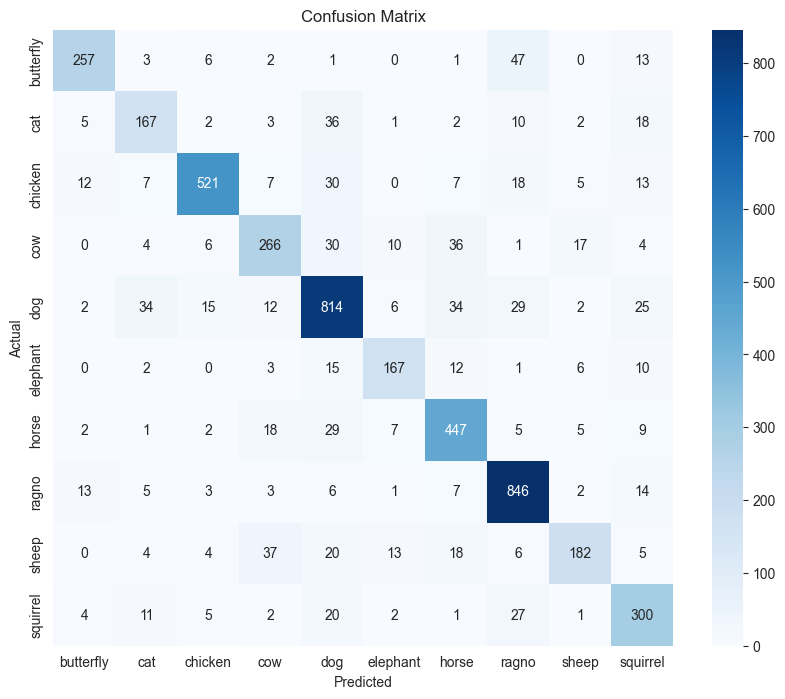

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.87      0.78      0.82       330
         cat       0.70      0.68      0.69       246
     chicken       0.92      0.84      0.88       620
         cow       0.75      0.71      0.73       374
         dog       0.81      0.84      0.82       973
    elephant       0.81      0.77      0.79       216
       horse       0.79      0.85      0.82       525
       ragno       0.85      0.94      0.90       900
       sheep       0.82      0.63      0.71       289
    squirrel       0.73      0.80      0.77       373

    accuracy                           0.82      4846
   macro avg       0.81      0.78      0.79      4846
weighted avg       0.82      0.82      0.82      4846



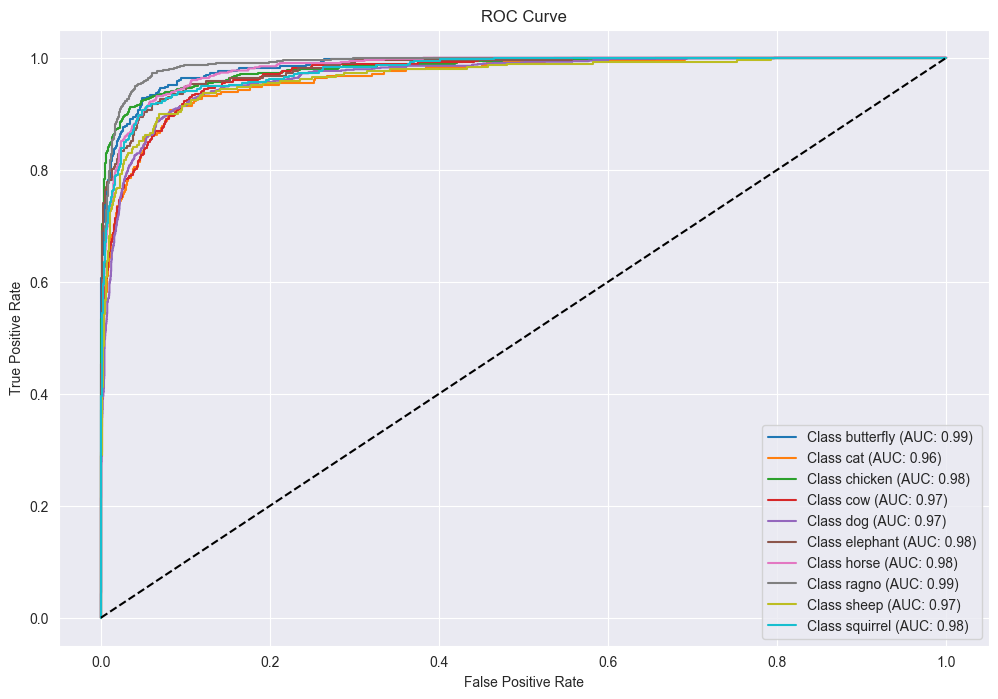

In [96]:
evaluate_model(model_phase_2, test_generator)

1/1 [==============================] - 0s 254ms/step


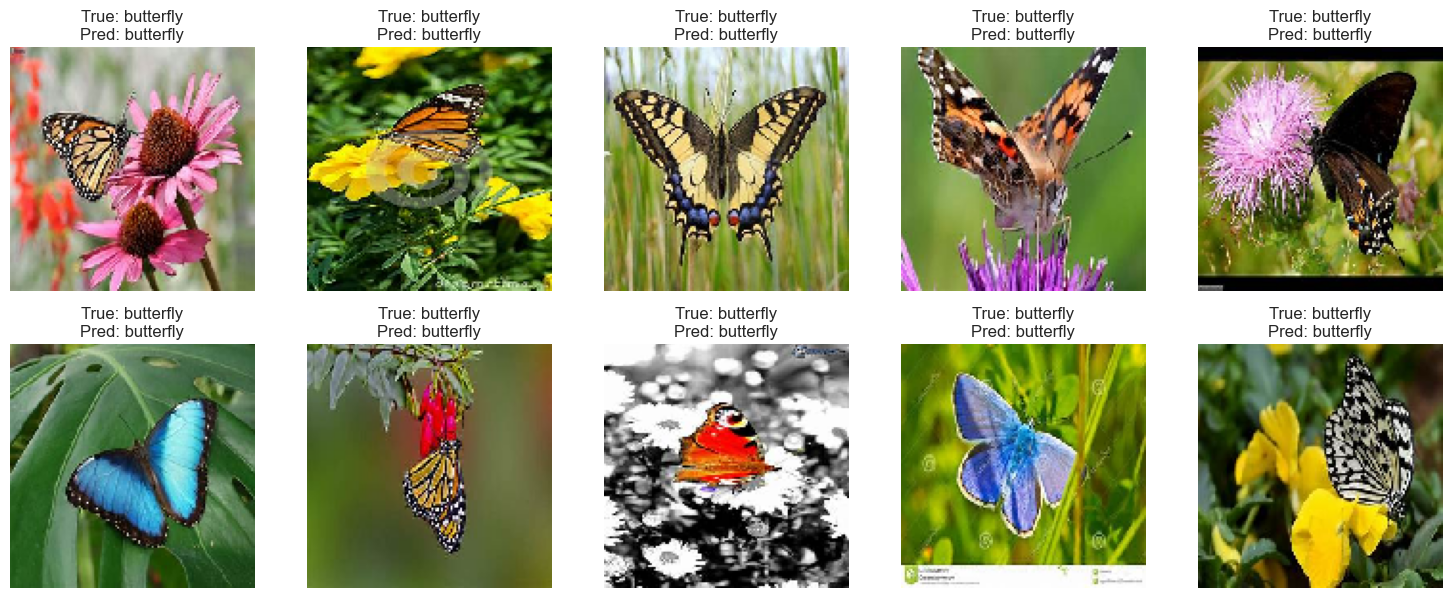

In [97]:
visualize_random_predictions(model_phase_2, test_generator)

# Execution for Phase 3: Prevent Overfitting (Phase 1 and Phase 2 models)

In [98]:
train_generator, val_generator, test_generator = create_data_generators(phase=3)

Found 16938 images belonging to 10 classes.
Found 2425 images belonging to 10 classes.
Found 4846 images belonging to 10 classes.


In [99]:
model_phase_1 = apply_overfitting_prevention(model_phase_1)
history_phase_1_overfit = train_model(model_phase_1, train_generator, val_generator, phase=3)

Epoch 1/20
530/530 [==============================] - ETA: 0s - loss: 1.1502 - accuracy: 0.6953
Epoch 1: val_loss improved from inf to 1.10341, saving model to phase3_best_model.h5
530/530 [==============================] - 425s 797ms/step - loss: 1.1502 - accuracy: 0.6953 - val_loss: 1.1034 - val_accuracy: 0.7493 - lr: 1.0000e-04
Epoch 2/20


D:\python 3.8.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


530/530 [==============================] - ETA: 0s - loss: 0.9072 - accuracy: 0.7244
Epoch 2: val_loss improved from 1.10341 to 0.94110, saving model to phase3_best_model.h5
530/530 [==============================] - 486s 917ms/step - loss: 0.9072 - accuracy: 0.7244 - val_loss: 0.9411 - val_accuracy: 0.7464 - lr: 1.0000e-04
Epoch 3/20
530/530 [==============================] - ETA: 0s - loss: 0.8337 - accuracy: 0.7303
Epoch 3: val_loss improved from 0.94110 to 0.93894, saving model to phase3_best_model.h5
530/530 [==============================] - 424s 799ms/step - loss: 0.8337 - accuracy: 0.7303 - val_loss: 0.9389 - val_accuracy: 0.7460 - lr: 1.0000e-04
Epoch 4/20
530/530 [==============================] - ETA: 0s - loss: 0.7871 - accuracy: 0.7456
Epoch 4: val_loss improved from 0.93894 to 0.93642, saving model to phase3_best_model.h5
530/530 [==============================] - 420s 793ms/step - loss: 0.7871 - accuracy: 0.7456 - val_loss: 0.9364 - val_accuracy: 0.7386 - lr: 1.0000e-04


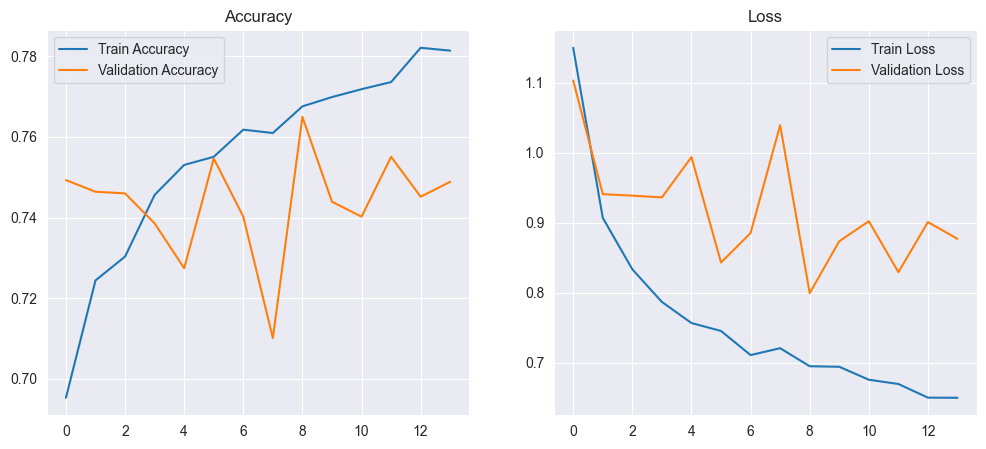

In [100]:
plot_learning_curves(history_phase_1_overfit)

152/152 [==============================] - 30s 198ms/step - loss: 0.7706 - accuracy: 0.7672
Test Loss: 0.7706352472305298
Test Accuracy: 0.7672306895256042
152/152 [==============================] - 29s 189ms/step


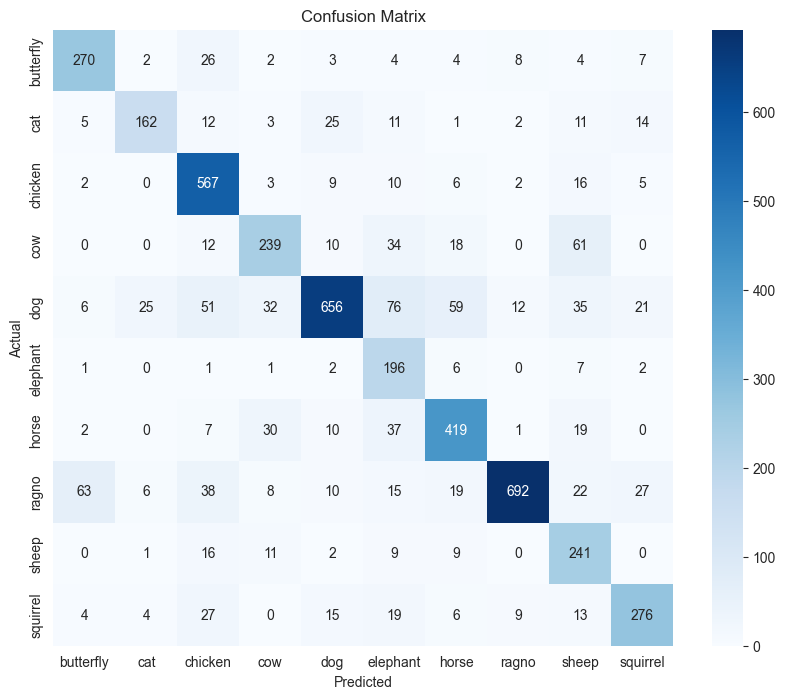

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.76      0.82      0.79       330
         cat       0.81      0.66      0.73       246
     chicken       0.75      0.91      0.82       620
         cow       0.73      0.64      0.68       374
         dog       0.88      0.67      0.77       973
    elephant       0.48      0.91      0.63       216
       horse       0.77      0.80      0.78       525
       ragno       0.95      0.77      0.85       900
       sheep       0.56      0.83      0.67       289
    squirrel       0.78      0.74      0.76       373

    accuracy                           0.77      4846
   macro avg       0.75      0.78      0.75      4846
weighted avg       0.80      0.77      0.77      4846



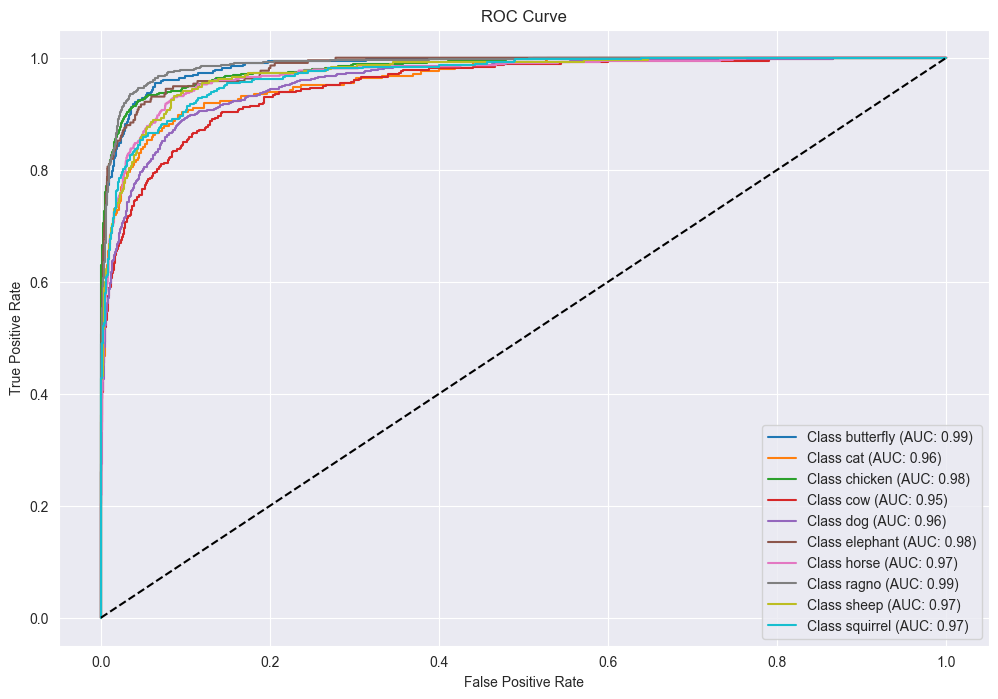

In [101]:
evaluate_model(model_phase_1, test_generator)

1/1 [==============================] - 0s 435ms/step


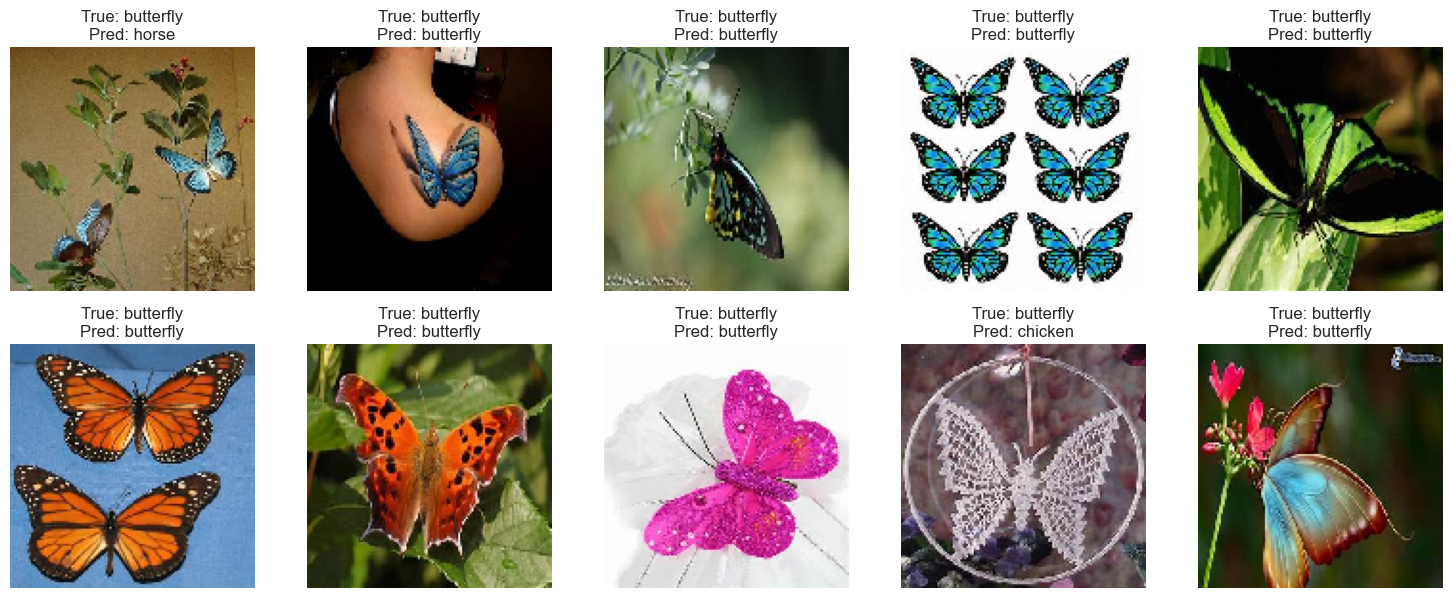

In [102]:
visualize_random_predictions(model_phase_1, test_generator)

In [103]:
model_phase_2 = apply_overfitting_prevention(model_phase_2)
history_phase_2_overfit = train_model(model_phase_2, train_generator, val_generator, phase=3)

Epoch 1/20
530/530 [==============================] - ETA: 0s - loss: 0.8341 - accuracy: 0.7539
Epoch 1: val_loss improved from inf to 1.13203, saving model to phase3_best_model.h5
530/530 [==============================] - 456s 856ms/step - loss: 0.8341 - accuracy: 0.7539 - val_loss: 1.1320 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 2/20


D:\python 3.8.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


530/530 [==============================] - ETA: 0s - loss: 0.7856 - accuracy: 0.7597
Epoch 2: val_loss did not improve from 1.13203
530/530 [==============================] - 438s 825ms/step - loss: 0.7856 - accuracy: 0.7597 - val_loss: 1.2030 - val_accuracy: 0.7175 - lr: 1.0000e-04
Epoch 3/20
530/530 [==============================] - ETA: 0s - loss: 0.7524 - accuracy: 0.7662
Epoch 3: val_loss improved from 1.13203 to 1.06887, saving model to phase3_best_model.h5
530/530 [==============================] - 437s 824ms/step - loss: 0.7524 - accuracy: 0.7662 - val_loss: 1.0689 - val_accuracy: 0.7381 - lr: 1.0000e-04
Epoch 4/20
530/530 [==============================] - ETA: 0s - loss: 0.7510 - accuracy: 0.7644
Epoch 4: val_loss improved from 1.06887 to 1.03851, saving model to phase3_best_model.h5
530/530 [==============================] - 440s 831ms/step - loss: 0.7510 - accuracy: 0.7644 - val_loss: 1.0385 - val_accuracy: 0.7386 - lr: 1.0000e-04
Epoch 5/20
530/530 [======================

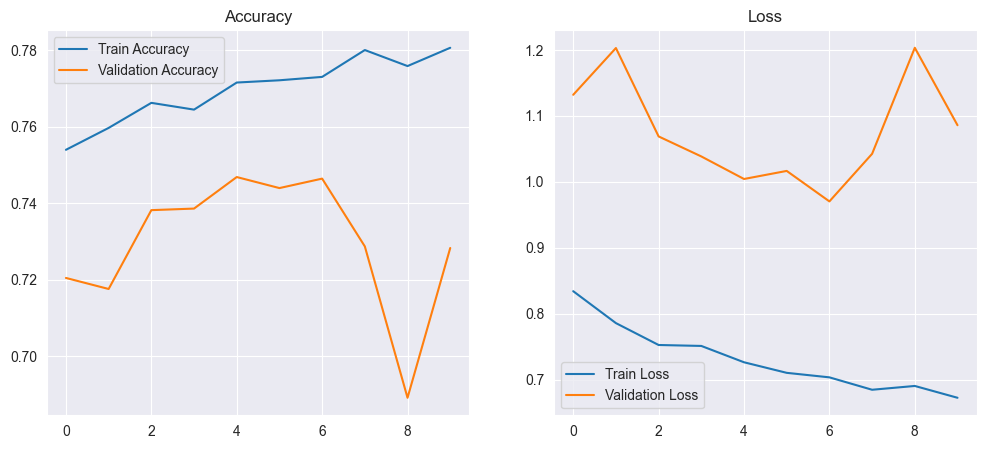

In [104]:
plot_learning_curves(history_phase_2_overfit)

152/152 [==============================] - 27s 180ms/step - loss: 0.9712 - accuracy: 0.7425
Test Loss: 0.9711652994155884
Test Accuracy: 0.742467999458313
152/152 [==============================] - 26s 173ms/step


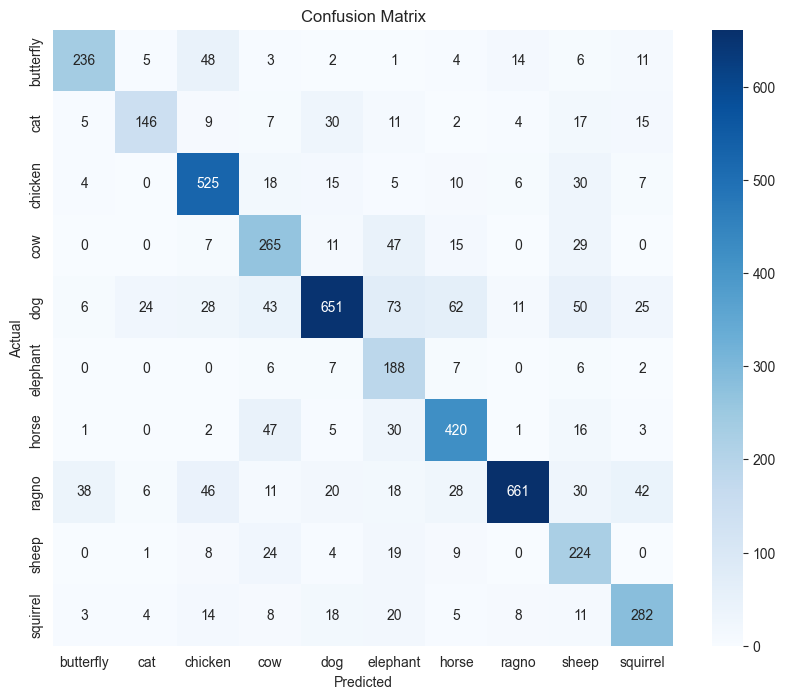

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.81      0.72      0.76       330
         cat       0.78      0.59      0.68       246
     chicken       0.76      0.85      0.80       620
         cow       0.61      0.71      0.66       374
         dog       0.85      0.67      0.75       973
    elephant       0.46      0.87      0.60       216
       horse       0.75      0.80      0.77       525
       ragno       0.94      0.73      0.82       900
       sheep       0.53      0.78      0.63       289
    squirrel       0.73      0.76      0.74       373

    accuracy                           0.74      4846
   macro avg       0.72      0.75      0.72      4846
weighted avg       0.77      0.74      0.75      4846



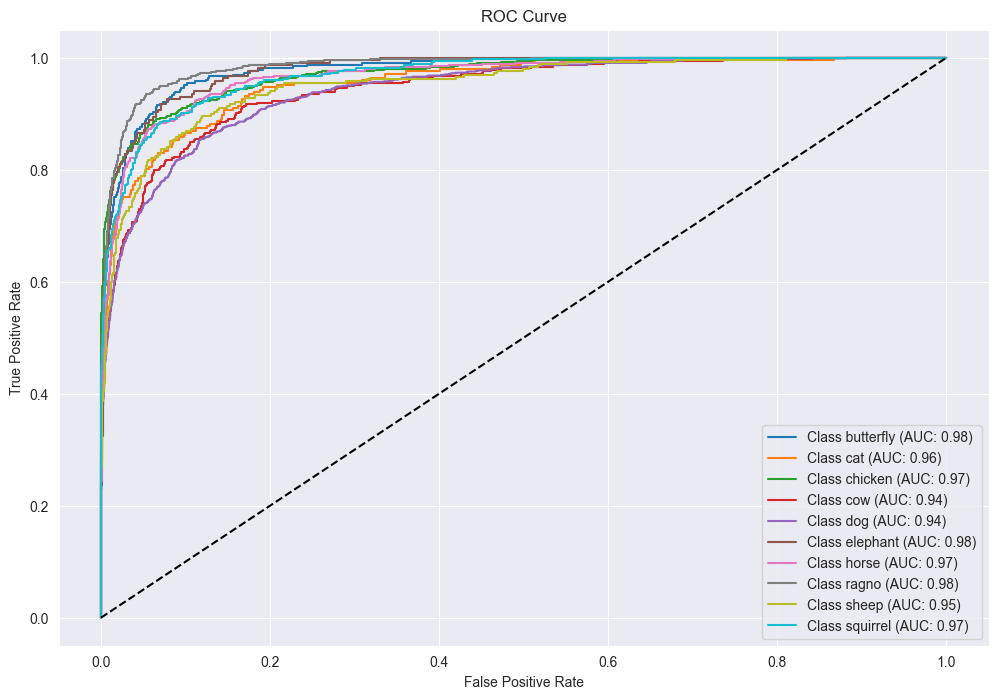

In [105]:
evaluate_model(model_phase_2, test_generator)

1/1 [==============================] - 0s 257ms/step


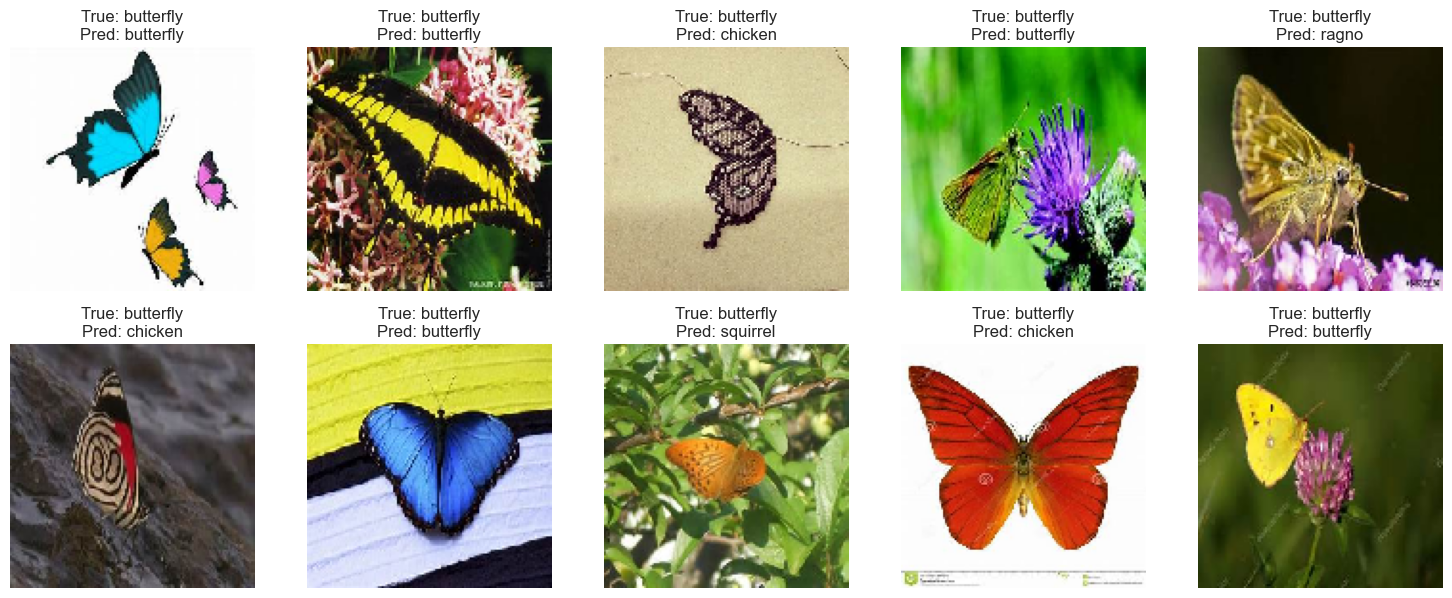

In [106]:
visualize_random_predictions(model_phase_2, test_generator)